# Building Markov state model with a toy system

We will use a toy system with four-well potential,

$V(x) = 4\left( x^8 + 0.8 e^{-80x^2} + 0.2 e^{-80(x-0.5)^2} + 0.5 e^{-40(x+0.5)^2} \right)$

In [568]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from math import *

In [569]:
V = lambda x: 4*(x**8 + 0.8*exp(-80*x**2) + 0.2*exp(-80*(x-0.5)**2) + 0.5*exp(-40*(x+0.5)**2))

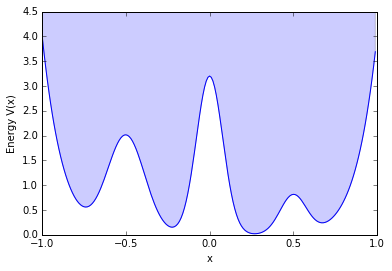

In [570]:
x = np.arange(-1, 1, 0.01)
y = np.vectorize(V)(x)
plt.plot(x, y)
plt.fill_between(x, y1=y, y2=4.5, alpha=0.2)
plt.xlabel("x")
plt.ylabel("Energy V(x)")
plt.show()

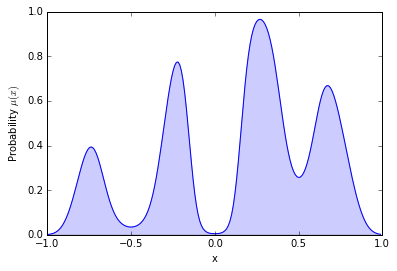

In [571]:
plt.plot(x, np.exp(-1/0.6*y))
plt.fill_between(x, y1=0, y2=np.exp(-1/0.6*y), alpha=0.2)
plt.xlabel("x")
plt.ylabel("Probability $\mu(x)$")
plt.show()

## Generate Trajectories

In [572]:
import random
def mc(x0=None, nstep=10, ifreq=10):
    history = []
    U0 = V(x0)

    m = 0
    for istep in range(nstep):
        x = x0 + random.uniform(-0.05, 0.05)
        U1 = V(x)
        doswap = U1 < U0 or np.exp(-(U1-U0)/0.6) > random.random()
        
        if doswap:
            x0 = x
            U0 = U1
        history.append(x)
        
    return np.array(history)[ifreq::ifreq]

In [573]:
print mc(0, 200, 10)

[ 0.28763971  0.19398435  0.17306193  0.26704635  0.29748918  0.44041867
  0.42080102  0.37026561  0.26745626  0.3594482   0.31821646  0.38596415
  0.37887403  0.18569442  0.23417215  0.36103575  0.39128987  0.28809272
  0.27674161]


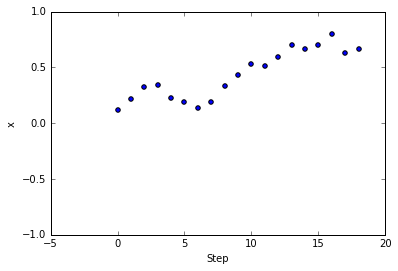

In [574]:
traj = mc(0, 200, 10)
plt.scatter(range(len(traj)), traj)
plt.ylim(-1, 1)
plt.xlabel("Step")
plt.ylabel("x")
plt.show()

In [575]:
trajs = [mc(-1.0+i*0.2, nstep=1000, ifreq=2) for i in range(10)]

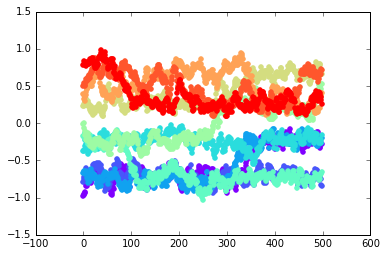

In [576]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(trajs)))
for i,traj in enumerate(trajs):
    plt.scatter(range(len(traj)), traj, color=colors[i])

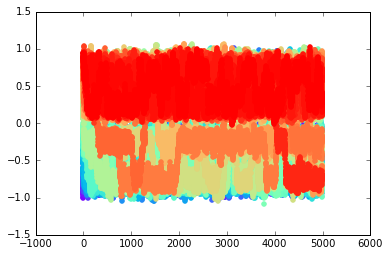

In [577]:
trajs = [mc(-1.0+i*0.02, nstep=10000, ifreq=2) for i in range(100)]
colors = cm.rainbow(np.linspace(0, 1, len(trajs)))
for i,traj in enumerate(trajs):
    plt.scatter(range(len(traj)), traj, color=colors[i])

## Discretize trajectories

Let's discretize the trajectory using binning. The trajectory spans from around -1 to 1, and I'd like to have 100 states. So, let's use 0.02 as the bin width (which will actually makes 101 states).

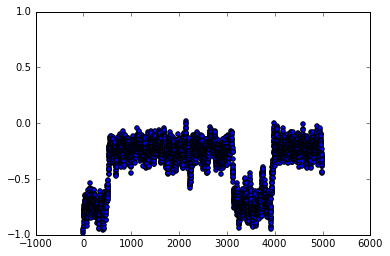

In [578]:
plt.scatter(range(len(trajs[0])), trajs[0])
plt.ylim(-1, 1)
plt.show()

In [579]:
xmin = -1
xmax = 1
delta = 0.02
nstates = int((xmax - xmin) / delta) + 1
def discretize(traj):
    traj_transformed = []
    for t in traj:
        d = (t - xmin + delta/2) / delta
        if d < 0 or d >= nstates: continue
        traj_transformed.append(d)
    return np.array(traj_transformed, dtype=np.integer)

traj_transformed = discretize(trajs[0])

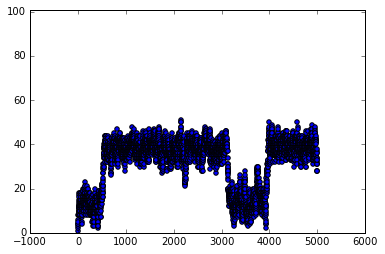

In [580]:
plt.scatter(range(len(traj_transformed)), traj_transformed)
plt.ylim(0, nstates)
plt.show()

In [581]:
trajs_transformed = [discretize(traj) for traj in trajs]

In [582]:
xmin = -1
xmax = 1
delta = 0.02
nstates = int((xmax - xmin) / delta) + 1
bins = [xmin - delta/2 + delta*i for i in range(nstates)]
traj_transformed = np.digitize(trajs[0], bins)

In [584]:
np.digitize((-1, 0.6, 0.5, 1.1), (0, 1, 2))

array([0, 1, 1, 2])

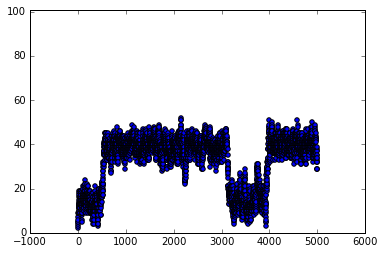

In [585]:
plt.scatter(range(len(traj_transformed)), traj_transformed)
plt.ylim(0, nstates)
plt.show()

In [586]:
%timeit discretize(trajs[0])
%timeit np.digitize(trajs[0], bins)

100 loops, best of 3: 4.67 ms per loop
10000 loops, best of 3: 188 µs per loop


## Build transition matrix

In [587]:
def build_transition_matrix(trajs, nstates, lag):
    T = np.zeros((nstates, nstates), dtype=np.integer)
    for traj in trajs:
        for i in range(0, len(traj)-lag):
            state_i = traj[i]
            state_j = traj[i+lag]
            T[state_i, state_j] += 1
    return T

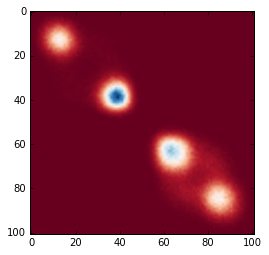

In [588]:
lag = 25
T = build_transition_matrix(trajs_transformed, nstates, lag)
plt.imshow(T, cmap=cm.RdBu, vmin=1)
plt.show()

In [589]:
def build_transition_matrix_np(trajs, nstates, lag):
    T = np.zeros((nstates, nstates), dtype=np.integer)
    for traj in trajs:
        states_i = traj[:-lag]
        states_j = traj[lag:]
        np.add.at(T, [states_i,states_j], 1)
    return T

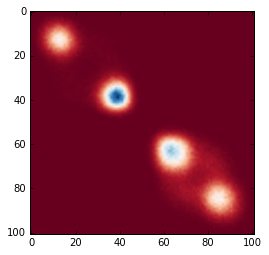

In [590]:
T = build_transition_matrix_np(trajs_transformed, nstates, lag)
plt.imshow(T, cmap=cm.RdBu, vmin=1)
plt.show()

In [591]:
%timeit build_transition_matrix(trajs_transformed, nstates, 10)
%timeit build_transition_matrix_np(trajs_transformed, nstates, 10)

1 loops, best of 3: 305 ms per loop
10 loops, best of 3: 42.8 ms per loop


Maximum likelihood estimator of transition probability matrix

$\hat P_{ij} = \frac{c_{ij}}{\sum_j c_{ij}}$

In [592]:
P = np.zeros((nstates, nstates), dtype=np.float)
for i in range(nstates):
    P[i,:] = T[i,:] / float(np.sum(T[i,:]))

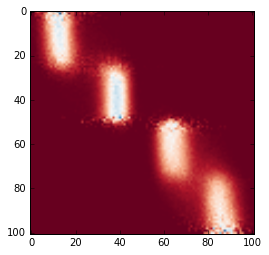

In [593]:
plt.imshow(P, cmap=cm.RdBu)
plt.show()

## Eigenfunction analysis

In [594]:
import scipy.linalg as la
l, vl, vr = la.eig(P, left=True)

In [604]:
idx = np.argsort(l)[-1]

In [595]:
indexes = np.argsort(l)[-4:][::-1]
print "four largest eigenvalues", l[indexes]

four largest eigenvalues [ 1.00000000+0.j  0.99485372+0.j  0.93051429+0.j  0.77013142+0.j]


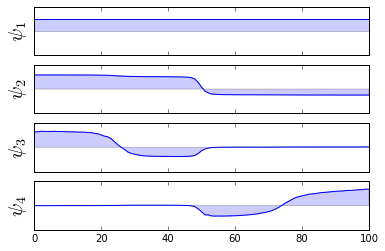

In [605]:
fig, ax = plt.subplots(4, sharex=True)
x = range(nstates)

for i in range(4):
    y = vr[:,indexes[i]]
    ax[i].plot(range(nstates), y)
    ax[i].fill_between(x, y1=y, y2=0, alpha=0.2)
    ax[i].set_ylim(-np.max(np.abs(y))-0.1, np.max(np.abs(y))+0.1)
    ax[i].get_yaxis().set_ticklabels([])
    ax[i].get_yaxis().set_ticks([])
    ax[i].set_ylabel('$\psi_%d$' % (i+1), fontsize=20)

plt.show()

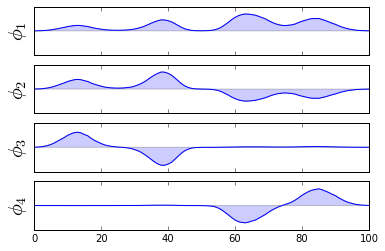

In [606]:
fig, ax = plt.subplots(4, sharex=True)
x = range(nstates)

for i in range(4):
    y = vl[:,indexes[i]]
    ax[i].plot(range(nstates), y)
    ax[i].fill_between(x, y1=y, y2=0, alpha=0.2)
    ax[i].set_ylim(-np.max(np.abs(y))-0.1, np.max(np.abs(y))+0.1)
    ax[i].get_yaxis().set_ticklabels([])
    ax[i].get_yaxis().set_ticks([])
    ax[i].set_ylabel('$\phi_%d$' % (i+1), fontsize=20)

plt.show()

## Implied timescale

/Users/sunhwan/local/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/sunhwan/local/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in divide


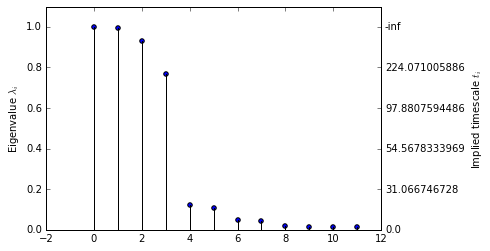

In [607]:
indexes = np.argsort(l)[-12:][::-1]
plt.scatter(range(len(indexes)), l[indexes])
for i in range(len(indexes)):
    plt.plot((i,i), (0,l[indexes[i]]), color='black')
plt.ylim(0, 1.1)
plt.axes().get_yaxis().set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylabel("Eigenvalue $\lambda_i$")

ax2 = plt.axes().twinx()
ax2.get_yaxis().set_ticklabels(-lag*2/np.log([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]))
ax2.set_ylim(0, 1.1)
ax2.set_ylabel('Implied timescale $t_i$')

plt.show()

In [608]:
n_components = 4
timescales = []
for lagt in (1, 2, 5, 10, 20, 40, 100):
    T = build_transition_matrix_np(trajs_transformed, nstates, lagt)
    
    P = np.zeros((nstates, nstates), dtype=np.float)
    for i in range(nstates):
        P[i,:] = T[i,:] / float(np.sum(T[i,:]))

    l, vl, vr = la.eig(P, left=True)
    
    indexes = np.argsort(l)[-n_components:-1][::-1]
    timescales.append(-lagt*2/np.log(l[indexes]))

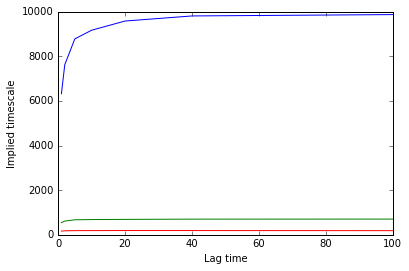

In [609]:
x = (1, 2, 5, 10, 20, 40, 100)
for i in range(n_components-1):
    y = [ts[i] for ts in timescales]
    plt.plot(x, y)
plt.xlabel('Lag time')
plt.ylabel('Implied timescale')
plt.show()

## Kolmogorov-Chapman Test

If system is Markovian, the following is assumed

$[\hat T(\tau)]^k \approx \hat T(k\tau)$

One can use the transition probability, $T(k\tau)$ obtained from simulation and the MSM, $T(\tau)$, to verify whether this assumption holds. For example, assume we start the simulation from an arbitrary set of states $i$, i.e., $w(i) = \pi_i/\sum_{j \in A} \pi_j$ if $i \in A$ other wise 0. Then, we calculate the probability of $p(A,A; k\tau) = \sum_{i \in A} w(i) p_\textrm{sim}(i,A; k\tau)$

$p_\textrm{sim}(A,A; k\tau) = \frac{\sum_{j \in A} c_{ij}^\textrm{obs} (k\tau)}{\sum_j c_{ij}^\textrm{obs} (k\tau)}$

Likewise, the probability of $p(A,A; k\tau)$ according to the Markov model is given by

$p_\textrm{MSM}(A,A; k\tau) = \sum_{i \in A} [w(i) T^k(\tau)]_i$

In [610]:
T = build_transition_matrix_np(trajs_transformed, nstates, 20)
P = np.zeros((nstates, nstates), dtype=np.float)
for i in range(nstates):
    P[i,:] = T[i,:] / float(np.sum(T[i,:]))
l, vl, vr = la.eig(P, left=True)
pi = vl[:,np.argsort(l)[-1]]

In [611]:
state_A = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
w = np.zeros(nstates)
w[state_A] = pi[state_A] / np.sum(pi[state_A])

/Users/sunhwan/local/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


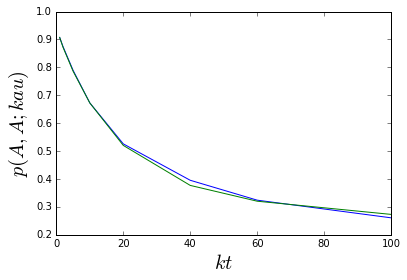

In [613]:
lagt = 20
x = (1, 2, 5, 10, 20, 40, 60, 100)
y1 = []
y2 = []
for k in x:
    T = build_transition_matrix_np(trajs_transformed, nstates, lagt*k)
    p = np.sum(T[state_A,:][:,state_A], axis=1)/np.sum(T[state_A,:], axis=1).astype(np.float)
    p_sim = np.dot(w[state_A], p)
    
    p = np.matrix(P)
    p_msm = np.sum((np.matrix(w) * p**k)[:,state_A])
    y1.append(p_sim)
    y2.append(p_msm)

plt.plot(x, y1)
plt.plot(x, y2)
plt.ylabel("$p(A,A; k\tau)$", fontsize=20)
plt.xlabel("$kt$", fontsize=20)
plt.show()